In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path

In [ ]:
# path = Path("../data/raw/")

# segment_path = path / "train_ship_segmentations_v2.csv"

# df_segment = pd.read_csv(segment_path)

In [5]:
# From https://www.kaggle.com/voglinio/from-masks-to-bounding-boxes
import cv2
from tqdm import tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.io import imread
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
from skimage.measure import label, regionprops
from skimage.util import montage
montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)
ship_dir = Path('../data/raw/')
train_image_dir = ship_dir / 'train_v2'
test_image_dir = ship_dir / 'test_v2'

from skimage.morphology import label
def multi_rle_encode(img):
    labels = label(img[:, :, 0])
    return [rle_encode(labels==k) for k in np.unique(labels[labels>0])]

# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

def masks_as_image(in_mask_list, all_masks=None):
    # Take the individual ship masks and create a single mask array for all ships
    if all_masks is None:
        all_masks = np.zeros((768, 768), dtype = np.int16)
    #if isinstance(in_mask_list, list):
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask)
    return np.expand_dims(all_masks, -1)

In [6]:
masks = pd.read_csv(ship_dir / 'train_ship_segmentations_v2.csv')
print(masks.shape[0], 'masks found')
print(masks['ImageId'].value_counts().shape[0])
masks.head()

231723 masks found
192556


,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [9]:
images_with_ship = masks.ImageId[masks.EncodedPixels.notnull()]
images_with_ship = np.unique(images_with_ship.values)
print(f'There are {images_with_ship.shape[0]} image files with masks')

There are 42556 image files with masks


In [12]:
images_with_ship[:10]

array(['000155de5.jpg', '000194a2d.jpg', '00021ddc3.jpg', '0002756f7.jpg',
       '00031f145.jpg', '000532683.jpg', '00053c6ba.jpg', '0005d01c8.jpg',
       '0005d6d95.jpg', '0006c52e8.jpg'], dtype=object)

In [10]:
from itertools import islice

In [17]:
train_image_dir / image

PosixPath('../data/raw/train_v2/000155de5.jpg')

In [29]:
mask_0[0,0]

array([0], dtype=int16)

TypeError: Only 2-D and 3-D images supported.

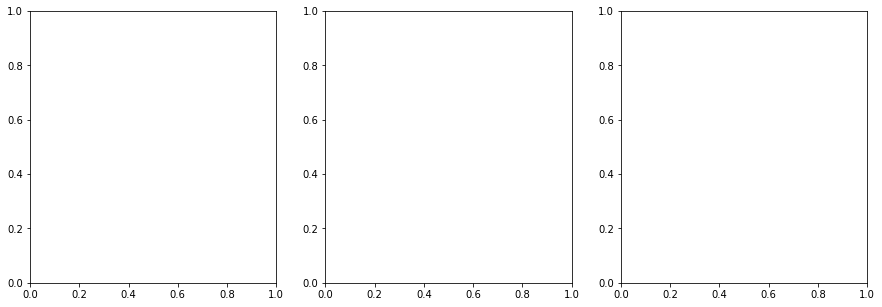

In [30]:
for image in islice(images_with_ship, 1):
#     image = images_with_ship[i]

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 5))
    img_0 = cv2.imread((train_image_dir / image).as_posix())
    rle_0 = masks.query(f"ImageId=='{image}'")['EncodedPixels']
    mask_0 = masks_as_image(rle_0)
    #
    # 
    lbl_0 = label(mask_0) 
#     print(f"label: {lbl_0}")
    props = regionprops(lbl_0)
    img_1 = img_0.copy()
    print ('Image', image)
    for prop in props:
        print('Found bbox', prop.bbox)
        cv2.rectangle(img_1, (prop.bbox[1], prop.bbox[0]), (prop.bbox[3], prop.bbox[2]), (255, 0, 0), 2)


    ax1.imshow(img_0)
    ax1.set_title('Image')
    ax2.set_title('Mask')
    ax3.set_title('Image with derived bounding box')
    ax2.imshow(mask_0[...,0], cmap='gray')
    ax3.imshow(img_1)
    plt.show()